<a href="https://colab.research.google.com/github/PriyankaGona/MachineLearning-Assignments/blob/master/Hw3_pretrained_convnet_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1: Feature Extraction Using Data Augmentation

In [161]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-15 20:39:54--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 2a00:1450:400c:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  51.5MB/s    in 1.3s    

2019-04-15 20:39:55 (51.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with VGG19 convolution base and custom densely connected layers

### Load the convolutional base

In [0]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3))

### Freeze the convolutional base

In [0]:
conv_base.trainable = False
for layer in conv_base.layers:
  layer.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

last_layer = conv_base.get_layer('block5_pool').output

network = layers.Flatten()(last_layer)
network = layers.Dense(256, activation='relu')(network)
network = layers.Dense(1, activation='sigmoid')(network)

model = models.Model(conv_base.input, network)



#model = models.Sequential()
#model.add(conv_base)
#model.add(layers.Flatten())
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
#model.add(layers.Dense(1, activation='sigmoid'))

In [167]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Train the model end to end with frozen convolutional base

In [168]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 55s 547ms/step - loss: 0.6215 - acc: 0.6550 - val_loss: 0.5272 - val_acc: 0.7070
Epoch 2/100
100/100 [==============================] - 49s 494ms/step - loss: 0.4708 - acc: 0.7800 - val_loss: 0.3428 - val_acc: 0.8520
Epoch 3/100
100/100 [==============================] - 50s 496ms/step - loss: 0.4277 - acc: 0.7925 - val_loss: 0.3079 - val_acc: 0.8740
Epoch 4/100
100/100 [==============================] - 50s 496ms/step - loss: 0.3745 - acc: 0.8285 - val_loss: 0.2689 - val_acc: 0.8880
Epoch 5/100
100/100 [==============================] - 49s 495ms/step - loss: 0.3702 - acc: 0.8375 - val_loss: 0.2754 - val_acc: 0.8830
Epoch 6/100
100/100 [==============================] - 50s 497ms/step - loss: 0.3590 - acc: 0.8370 - val_loss: 0.2546 - val_acc: 0.8940
Epoch 7/100
100/100 [==============================] - 50s 495ms/step - loss: 0.3359 - acc: 0.8530 -

## Display curves of loss and accuracy during training

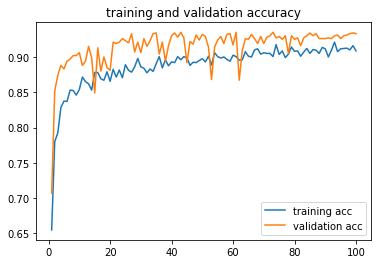

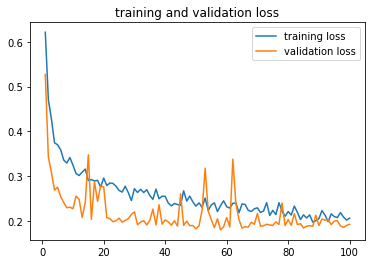

In [169]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc,  label='training acc')
plt.plot(epochs, val_acc,  label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss,  label='training loss')
plt.plot(epochs, val_loss,  label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

# Problem 2:  Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [171]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 56s 562ms/step - loss: 0.2315 - acc: 0.8985 - val_loss: 0.1872 - val_acc: 0.9280
Epoch 2/100
100/100 [==============================] - 51s 511ms/step - loss: 0.1907 - acc: 0.9160 - val_loss: 0.1470 - val_acc: 0.9550
Epoch 3/100
100/100 [==============================] - 51s 511ms/step - loss: 0.1871 - acc: 0.9190 - val_loss: 0.1584 - val_acc: 0.9360
Epoch 4/100
100/100 [==============================] - 54s 541ms/step - loss: 0.1546 - acc: 0.9300 - val_loss: 0.1465 - val_acc: 0.9550
Epoch 5/100
100/100 [==============================] - 51s 513ms/step - loss: 0.1470 - acc: 0.9420 - val_loss: 0.1468 - val_acc: 0.9440
Epoch 6/100
100/100 [==============================] - 51s 515ms/step - loss: 0.1379 - acc: 0.9460 - val_loss: 0.1643 - val_acc: 0.9480
Epoch 7/100
100/100 [==============================] - 51s 513ms/step - loss: 0.1239 - acc: 0.9495 - val_loss: 0.1436 - val_acc: 0.9560
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

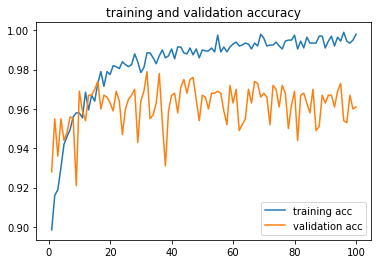

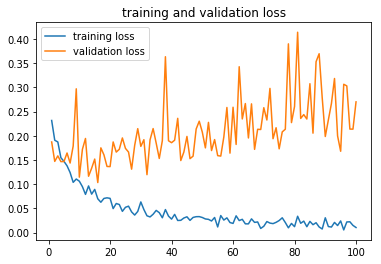

In [172]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc,  label='training acc')
plt.plot(epochs, val_acc,  label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss,  label='training loss')
plt.plot(epochs, val_loss,  label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This looks like overfitting. I should try  adding dropout for the densely connected layer.

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [174]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.20096379161496727
Validation accuracy: 0.9649999928474426


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
#from google.colab import files

#with open(model_fname, 'r') as f:
  #files.download(model_fname)

# Problem 3: Heat Map Visualization

In [0]:
last_conv_layer = model.get_layer('block5_conv4')

In [0]:
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
import numpy as np
from keras import backend as K

In [179]:
!ls /tmp/cats_and_dogs_filtered/validation/cats | head -3
!ls /tmp/cats_and_dogs_filtered/validation/dogs | head -3

cat.2000.jpg
cat.2001.jpg
cat.2002.jpg
dog.2000.jpg
dog.2001.jpg
dog.2002.jpg


In [0]:

def show_superimposed_image(img_path, heatmap):

  img = cv2.imread(img_path)
  # resize the heatmap to be the same size as the original image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap * 0.4 + img

  cv2_imshow(superimposed_img)

In [0]:
def process_image(img_path, idx=0):
  img = image.load_img(img_path, target_size=(224, 224))
  #
  plt.imshow(img)
  plt.grid(None)
  plt.show()
  #
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  preds = model.predict(x)
  #print('Predicted:', decode_predictions(preds, top=3)[0])
  #
  #class_index = np.argmax(preds[0])
  
  class_index = np.argsort(preds[0])[-(1+idx)]
  
  class_output = model.output[:, class_index]
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]

  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  #for i in range(512):
  #  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  show_superimposed_image(img_path, heatmap)

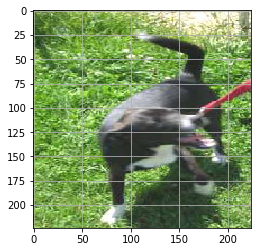

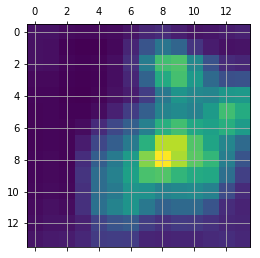

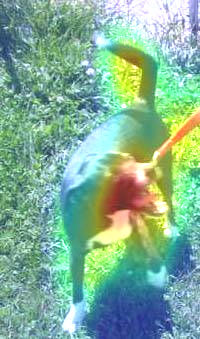

In [182]:
process_image('/tmp/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg')


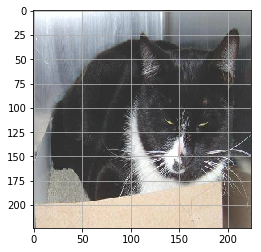

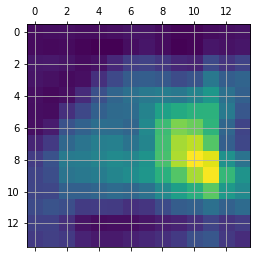

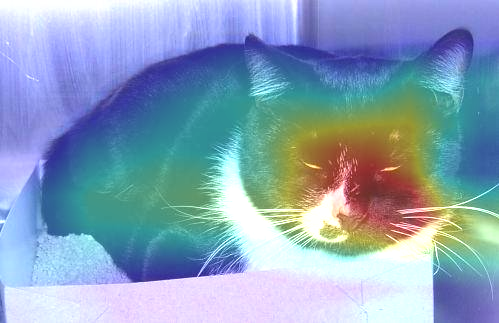

In [183]:
process_image('/tmp/cats_and_dogs_filtered/validation/cats/cat.2001.jpg')

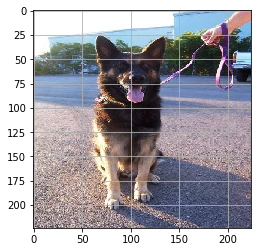

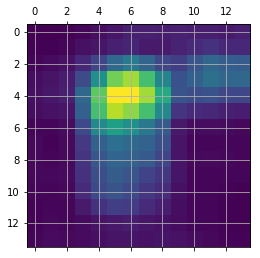

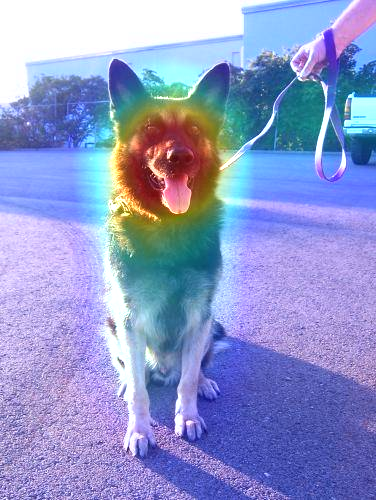

In [184]:
process_image('/tmp/cats_and_dogs_filtered/validation/dogs/dog.2002.jpg')